#1- File Selection:

In [ ]:
import pandas as pd

def dataset_info(data):
    """
    Display basic information about the dataset including:
    - First few rows
    - Dataset shape
    - Column names and data types
    - Summary statistics for numeric columns
    - Missing values in each column

    Parameters:
    data (DataFrame): The dataset to analyze

    Returns:
    None
    """
    # Display the first few rows of the dataset
    print("First few rows of the dataset:")
    print(data.head())

    # Check the shape of the dataset
    print("\nDataset shape (rows, columns):", data.shape)

    # Display column names and data types
    print("\nColumn names and data types:")
    print(data.dtypes)

    # Show basic statistical details for numeric columns
    print("\nSummary statistics for numeric columns:")
    print(data.describe())

    # Check for any missing values
    print("\nMissing values in each column:")
    print(data.isnull().sum())


#2- Initial Exploration

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_features(data):
    """
    Analyze the dataset by:
    - Checking unique values in nominal and binary columns
    - Analyzing target variable distribution
    - Calculating summary statistics for integer and float columns
    - Visualizing distributions for numeric features

    Parameters:
    data (DataFrame): The dataset to analyze

    Returns:
    None
    """
    # Define the feature types based on provided details
    nominal_cols = ['srcip', 'dstip', 'proto', 'state', 'service', 'attack_cat']
    integer_cols = [
        'sport', 'dsport', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Spkts',
        'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth',
        'res_bdy_len', 'ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd', 'ct_srv_src',
        'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
        'ct_dst_src_ltm'
    ]
    float_cols = [
        'dur', 'Sload', 'Dload', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat'
    ]
    binary_cols = ['is_sm_ips_ports', 'is_ftp_login', 'label']
    timestamp_cols = ['Stime', 'Ltime']

    # Step 1: Checking unique values in nominal and binary columns
    print("Unique values in nominal columns:")
    for col in nominal_cols:
        if col in data.columns:
            print(f"{col}: {data[col].nunique()} unique values")
        else:
            print(f"Column '{col}' not found in the DataFrame.")

    print("\nUnique values in binary columns:")
    for col in binary_cols:
        if col in data.columns:
            print(f"{col}: {data[col].value_counts().to_dict()}")
        else:
            print(f"Column '{col}' not found in the DataFrame.")

    # Step 2: Analyze target variable distribution ('label' and 'attack_cat')
    print("\nValue counts for 'label':")
    if 'label' in data.columns:
        print(data['label'].value_counts())
    else:
        print("Column 'label' not found in the DataFrame.")

    if 'attack_cat' in data.columns:
        print("\nValue counts for 'attack_cat':")
        print(data['attack_cat'].value_counts())

    # Step 3: Summary statistics for integer and float columns
    print("\nSummary statistics for integer columns:")

    # Create copies of the lists to avoid modifying the original lists during iteration
    valid_integer_cols = [col for col in integer_cols if col in data.columns]
    valid_float_cols = [col for col in float_cols if col in data.columns]

    # Print warnings for missing columns
    missing_integer_cols = set(integer_cols) - set(valid_integer_cols)
    missing_float_cols = set(float_cols) - set(valid_float_cols)

    if missing_integer_cols:
        print(f"Warning: Integer columns not found in DataFrame: {missing_integer_cols}")
    if missing_float_cols:
        print(f"Warning: Float columns not found in DataFrame: {missing_float_cols}")

    # Calculate and print summary statistics
    if valid_integer_cols:
        print(data[valid_integer_cols].describe())

    if valid_float_cols:
        print("\nSummary statistics for float columns:")
        print(data[valid_float_cols].describe())

    # Step 4: Visualize distributions for numeric features
    print("\nVisualizing distributions for numeric features...")

    # Plot distributions for integer columns
    for col in valid_integer_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(data[col].dropna(), bins=30, kde=True)
        plt.title(f"Distribution of {col} (Integer)")
        plt.show()

    # Plot distributions for float columns
    for col in valid_float_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(data[col].dropna(), bins=30, kde=True)
        plt.title(f"Distribution of {col} (Float)")
        plt.show()


#3- Data Cleaning

##3.1- Missing values

In [ ]:
def handle_missing_values(data):
    """
    This function checks for missing values in each column of the DataFrame,
    removes rows with missing values, and confirms that no missing values remain.

    Parameters:
    data (DataFrame): The dataset to clean

    Returns:
    DataFrame: Cleaned dataset with no missing values
    """

    # Step 1: Check for missing values in each column
    missing_values = data.isnull().sum()
    print("Missing values in each column before cleaning:")
    print(missing_values[missing_values > 0])

    # Step 2: Remove rows with missing values
    data_cleaned = data.dropna()
    print(f"\nData shape after removing rows with missing values: {data_cleaned.shape}")

    # Step 3: Confirm no missing values remain
    missing_values_after = data_cleaned.isnull().sum().sum()
    if missing_values_after == 0:
        print("\nNo missing values remain after cleaning.")
    else:
        print(f"\nWarning: {missing_values_after} missing values still remain.")

    return data_cleaned


##3.1- Outliers/anomlies: (REMOVES A LARGE AMOUNT! To be verfied)

In [ ]:
def remove_outliers_iqr(data, columns, threshold=1.5):
    """
    Removes outliers from specified columns in a DataFrame using the IQR method.

    Parameters:
    data (DataFrame): The dataset to clean
    columns (list): List of column names to check for outliers
    threshold (float): Multiplier for the IQR to define outlier bounds (default is 1.5)

    Returns:
    DataFrame: Dataset with outliers removed
    """
    data_no_outliers = data.copy()
    initial_shape = data_no_outliers.shape[0]  # For tracking removed rows

    for col in columns:
        if col in data_no_outliers.columns:
            # Calculate IQR
            Q1 = data_no_outliers[col].quantile(0.25)
            Q3 = data_no_outliers[col].quantile(0.75)
            IQR = Q3 - Q1
            # Define bounds
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            # Filter out outliers
            data_no_outliers = data_no_outliers[(data_no_outliers[col] >= lower_bound) &
                                                (data_no_outliers[col] <= upper_bound)]

    # Optional: Calculate and print the percentage of rows removed
    rows_removed = initial_shape - data_no_outliers.shape[0]
    percentage_removed = (rows_removed / initial_shape) * 100
    print(f"Data shape after removing outliers: {data_no_outliers.shape}")
    print(f"Percentage of rows removed as outliers: {percentage_removed:.2f}%")

    return data_no_outliers


#4- Feature Engineering

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

def feature_engineering(data, numeric_cols, nominal_cols_one_hot=['proto', 'state', 'service'], binary_col='attack_cat'):
    """
    Perform feature engineering by encoding categorical features, scaling numeric features,
    and optionally extracting time-based features from timestamp columns.

    Parameters:
    data (DataFrame): The cleaned dataset to process
    numeric_cols (list): List of numeric columns to scale
    nominal_cols_one_hot (list): List of nominal columns to one-hot encode
    binary_col (str): Binary or multi-class column to label encode (default is 'attack_cat')

    Returns:
    DataFrame: Dataset after feature engineering
    """
    data_fe = data.copy()

    # Step 1: Encoding categorical features

    # One-hot encode multi-category nominal features
    data_fe = pd.get_dummies(data_fe, columns=[col for col in nominal_cols_one_hot if col in data_fe.columns])

    # Label encode binary categorical column (e.g., attack_cat)
    if binary_col in data_fe.columns:
        le = LabelEncoder()
        data_fe[binary_col] = le.fit_transform(data_fe[binary_col])

    # Step 2: Scale numeric features
    # Ensure all numeric_cols are present in the DataFrame
    numeric_cols_present = [col for col in numeric_cols if col in data_fe.columns]

    # If any columns are missing, print a warning and proceed with available columns
    missing_cols = set(numeric_cols) - set(numeric_cols_present)
    if missing_cols:
        print(f"Warning: The following numeric columns are not in the DataFrame and were skipped during scaling: {missing_cols}")

    #If there are columns to scale
    if numeric_cols_present:
      scaler = StandardScaler()
      data_fe[numeric_cols_present] = scaler.fit_transform(data_fe[numeric_cols_present])

    # Step 3: Feature extraction from timestamps (optional)
    if 'Stime' in data_fe.columns:
        data_fe['Stime_hour'] = pd.to_datetime(data_fe['Stime'], unit='s').dt.hour
        data_fe['Stime_day'] = pd.to_datetime(data_fe['Stime'], unit='s').dt.day
        data_fe.drop(columns=['Stime'], inplace=True)

    if 'Ltime' in data_fe.columns:
        data_fe['Ltime_hour'] = pd.to_datetime(data_fe['Ltime'], unit='s').dt.hour
        data_fe['Ltime_day'] = pd.to_datetime(data_fe['Ltime'], unit='s').dt.day
        data_fe.drop(columns=['Ltime'], inplace=True)

    # Display final DataFrame shape and columns
    print("Final DataFrame shape:", data_fe.shape)
    print("DataFrame columns after feature engineering:", data_fe.columns)

    return data_fe

**Must consider High dimentionality problems.. change encoding type or utilize techniques such as**
- Correlation Analysis
- Variance Thresholding
- Feature Importance with Random Forest.


#5- Training and evaluation function:

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Train a model on the training set and evaluate it on the test set.

    Parameters:
    model (object): The machine learning model to train (e.g., RandomForestClassifier, GradientBoostingClassifier)
    X_train (DataFrame): Features for training
    y_train (Series): Target for training
    X_test (DataFrame): Features for testing
    y_test (Series): Target for testing

    Returns:
    model (object): Trained model
    """

    # Step 1: Train the model
    model.fit(X_train, y_train)

    # Step 2: Make predictions on the test set
    y_pred = model.predict(X_test)

    # Step 3: Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')  # Use 'macro' for multi-class
    recall = recall_score(y_test, y_pred, average='binary')  # Use 'macro' for multi-class
    f1 = f1_score(y_test, y_pred, average='binary')  # Use 'macro' for multi-class
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Display the evaluation results
    print("Model Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)

    return model


#For Testing purposes we will use the prepared split data for a model:

<ipython-input-7-c525775bdd0c>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='attack_cat', order=data['attack_cat'].value_counts().index, palette='viridis')


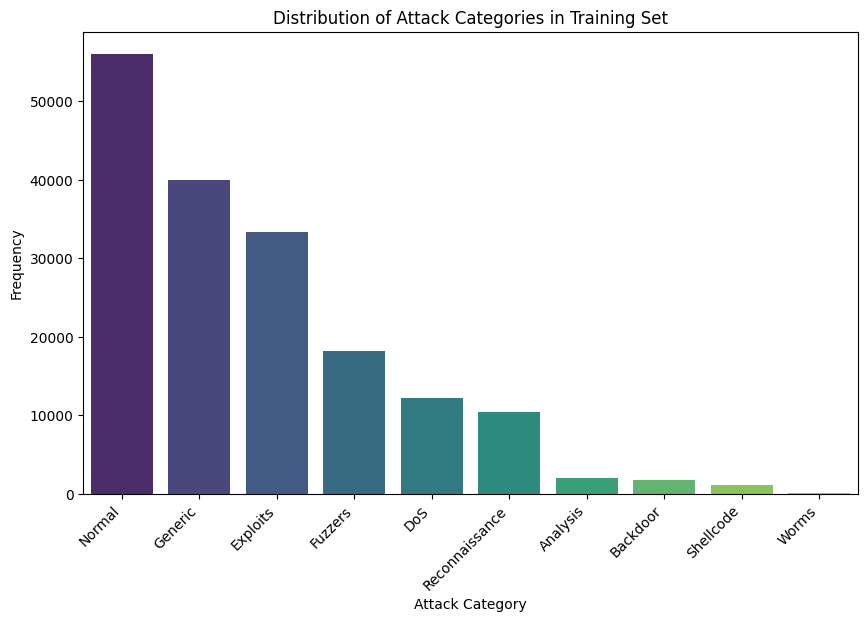

<ipython-input-7-c525775bdd0c>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='attack_cat', order=data['attack_cat'].value_counts().index, palette='viridis')


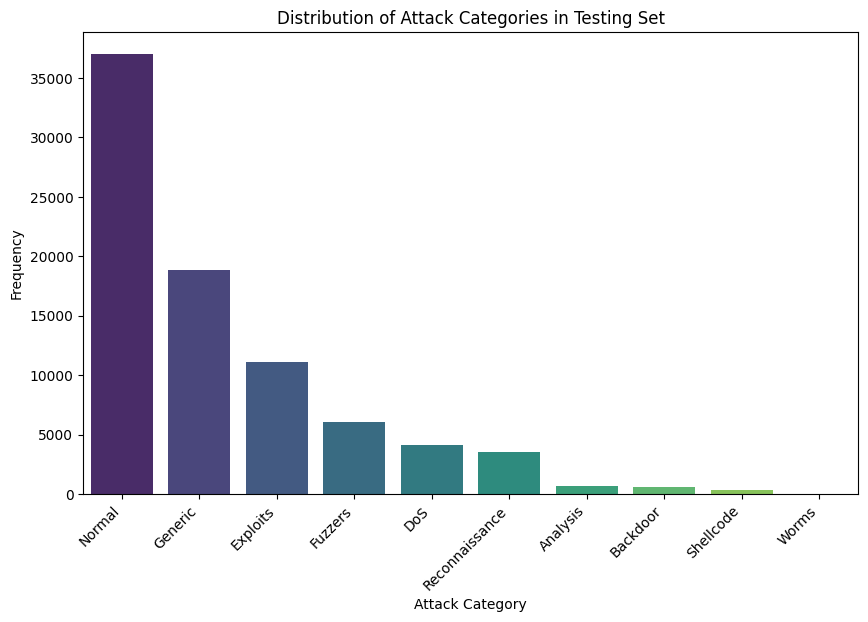

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to plot distribution of attack categories
def plot_attack_distribution(data, dataset_name):
    """
    Plot the distribution of attack categories in the dataset.

    Parameters:
    data (DataFrame): The dataset containing the 'attack_cat' column
    dataset_name (str): Name of the dataset (e.g., "Training Set", "Testing Set")
    """
    # Check if 'attack_cat' column exists
    if 'attack_cat' in data.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=data, x='attack_cat', order=data['attack_cat'].value_counts().index, palette='viridis')
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Distribution of Attack Categories in {dataset_name}')
        plt.xlabel('Attack Category')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print(f"'attack_cat' column not found in {dataset_name}")

train_path = '/content/UNSW_NB15_training-set.csv'
test_path = '/content/UNSW_NB15_testing-set.csv'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
# Plot distribution for training and testing datasets
plot_attack_distribution(train_data, "Training Set")
plot_attack_distribution(test_data, "Testing Set")


**When using the prepared testing/training set use the following code**

In [ ]:
# Define the column types based on provided information
nominal_cols = ['srcip', 'dstip', 'proto', 'state', 'service', 'attack_cat']
integer_cols = [
    'sport', 'dsport', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Spkts',
    'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth',
    'res_bdy_len', 'ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd', 'ct_srv_src',
    'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
    'ct_dst_src_ltm'
]
float_cols = [
    'dur', 'sload', 'dload', 'sjit', 'djit', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat'
]
binary_cols = ['is_sm_ips_ports', 'is_ftp_login', 'label']
numeric_cols = integer_cols + float_cols

# Load the pre-split data
train_path = '/content/UNSW_NB15_training-set.csv'
test_path = '/content/UNSW_NB15_testing-set.csv'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Apply functions to the training set
print("Training Set Information:")
dataset_info(train_data)
train_data_cleaned = handle_missing_values(train_data)
train_data_outliers = remove_outliers_iqr(train_data_cleaned, numeric_cols)
train_data_fe = feature_engineering(train_data_outliers, numeric_cols)


# Apply functions to the testing set
print("\nTesting Set Information:")
dataset_info(test_data)
test_data_cleaned = handle_missing_values(test_data)
test_data_outliers = remove_outliers_iqr(test_data_cleaned, numeric_cols)
test_data_fe = feature_engineering(test_data_outliers, numeric_cols)

# Display final shapes of the processed training and testing sets
print("\nFinal shape of processed training set:", train_data_fe.shape)
print("Final shape of processed testing set:", test_data_fe.shape)

Training Set Information:
First few rows of the dataset:
   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_d

Without outlier removal:


In [ ]:
# Define the column types based on provided information
nominal_cols = ['srcip', 'dstip', 'proto', 'state', 'service', 'attack_cat']
integer_cols = [
    'sport', 'dsport', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Spkts',
    'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth',
    'res_bdy_len', 'ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd', 'ct_srv_src',
    'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
    'ct_dst_src_ltm'
]
float_cols = [
    'dur', 'sload', 'dload', 'sjit', 'djit', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat'
]
binary_cols = ['is_sm_ips_ports', 'is_ftp_login', 'label']
numeric_cols = integer_cols + float_cols

# Load the pre-split data
train_path = '/content/UNSW_NB15_training-set.csv'
test_path = '/content/UNSW_NB15_testing-set.csv'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Apply functions to the training set
print("Training Set Information:")
dataset_info(train_data)
train_data_cleaned = handle_missing_values(train_data)
train_data_fe = feature_engineering(train_data_cleaned, numeric_cols)


# Apply functions to the testing set
print("\nTesting Set Information:")
dataset_info(test_data)
test_data_cleaned = handle_missing_values(test_data)
test_data_fe = feature_engineering(test_data_cleaned, numeric_cols)

# Display final shapes of the processed training and testing sets
print("\nFinal shape of processed training set:", train_data_fe.shape)
print("Final shape of processed testing set:", test_data_fe.shape)

Training Set Information:
First few rows of the dataset:
   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_d

In [ ]:
# Define target and features for training and testing sets
X_train = train_data_fe.drop(columns=['id','label','attack_cat'])
y_train = train_data_fe['label']
X_test = test_data_fe.drop(columns=['id','label','attack_cat'])
y_test = test_data_fe['label']

#MODELS:

##Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
# You can adjust the parameters to optimize performance as needed
model = RandomForestClassifier(
    n_estimators=100,       # Number of trees in the forest
    max_depth=None,         # Maximum depth of the tree (None means nodes are expanded until all leaves are pure or contain < min_samples_split samples)
    min_samples_split=2,    # Minimum number of samples required to split an internal node
    min_samples_leaf=1,     # Minimum number of samples required to be at a leaf node
    random_state=42,        # Ensures reproducibility
    n_jobs=-1               # Use all available processors
)




In [ ]:
# Get the common features
common_features = list(set(X_train.columns) & set(X_test.columns))

# Select only the common features in both training and testing data
X_train = X_train[common_features]
X_test = X_test[common_features]

# Now, retrain your model and evaluate it
trained_model = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)

Model Evaluation Metrics:
Accuracy: 0.8130
Precision: 0.7471
Recall: 0.9982
F1 Score: 0.8546

Confusion Matrix:
[[21686 15314]
 [   82 45250]]


In [ ]:
# Get the common features
common_features = list(set(X_train.columns) & set(X_test.columns))

# Select only the common features in both training and testing data
X_train = X_train[common_features]
X_test = X_test[common_features]

# Now, retrain your model and evaluate it
trained_model = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)

Model Evaluation Metrics:
Accuracy: 0.9196
Precision: 0.9196
Recall: 1.0000
F1 Score: 0.9581

Confusion Matrix:
[[   19  1830]
 [    0 20922]]


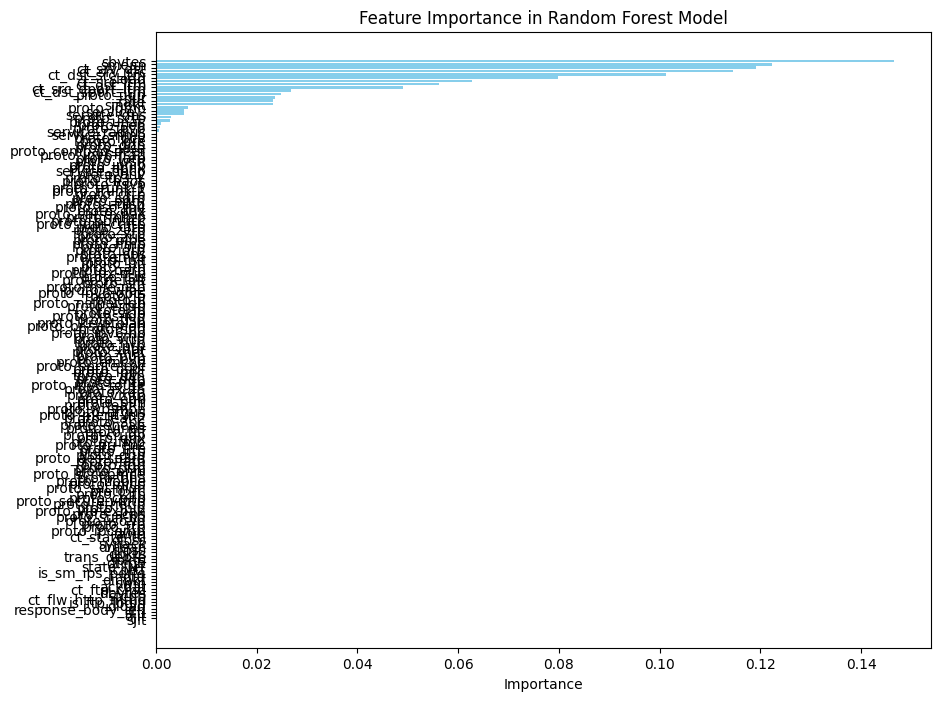

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Step 1: Extract feature importances
feature_importances = model.feature_importances_

# Step 2: Sort feature importances and match with feature names
features = X_train.columns  # Get feature names
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 3: Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()


In [ ]:
# Step 1: Calculate feature importances after training the model
feature_importances = model.feature_importances_

# Step 2: Set a threshold to keep only important features
importance_threshold = 0.02 # You can adjust this threshold
important_features = [feature for feature, importance in zip(X_train.columns, feature_importances) if importance >= importance_threshold]

# Step 3: Create a new dataset with only important features
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

# Step 4: Train the Random Forest model again using the important features
model_important = RandomForestClassifier(
    n_estimators=100,       # Number of trees in the forest
    max_depth=5,         # Maximum depth of the tree (None means nodes are expanded until all leaves are pure or contain < min_samples_split samples)
    min_samples_split=30,    # Minimum number of samples required to split an internal node
    min_samples_leaf=15,
    # Minimum number of samples required to be at a leaf node
    random_state=42,        # Ensures reproducibility
    n_jobs=-1,               # Use all available processors
    class_weight= 'balanced',
)




In [ ]:
# Get the common features
common_features = list(set(X_train_important.columns) & set(X_test_important.columns))

# Select only the common features in both training and testing data
X_train_important = X_train_important[common_features]
X_test_important = X_test_important[common_features]

# Now, retrain your model and evaluate it
trained_model = train_and_evaluate_model(model_important, X_train_important, y_train, X_test_important, y_test)

Model Evaluation Metrics:
Accuracy: 0.9521
Precision: 0.9652
Recall: 0.9833
F1 Score: 0.9742

Confusion Matrix:
[[ 1108   741]
 [  349 20573]]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'max_depth': [2,5, 10, 15],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15,20],
    'class_weight': ['balanced', 'balanced_subsample']
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, scoring='precision', cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Best Model Precision:", precision_score(y_test, y_pred_best))


Best Model Precision: 0.9862953995157385


In [ ]:
print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 15, 'min_samples_split': 30}


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("Best Model Precision:", precision_score(y_test, y_pred_best))
print("Best Model Recall:", recall_score(y_test, y_pred_best))
print("Best Model F1 Score:", f1_score(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))


Best Model Accuracy: 0.9631988054982215
Best Model Precision: 0.9862953995157385
Best Model Recall: 0.9734728993404073
Best Model F1 Score: 0.9798422014817666
Confusion Matrix:
 [[ 1566   283]
 [  555 20367]]


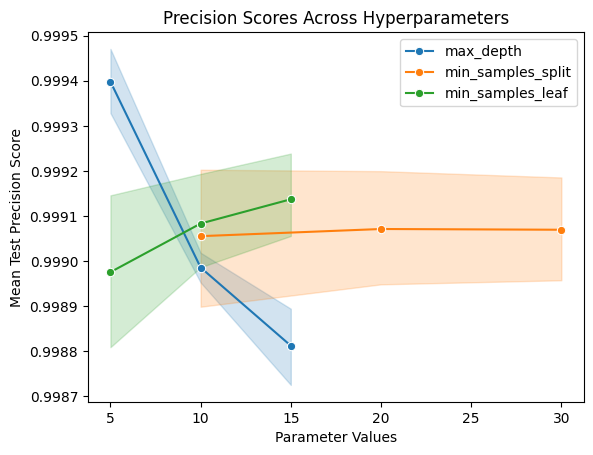

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=results['param_max_depth'], y=results['mean_test_score'], marker='o', label='max_depth')
sns.lineplot(x=results['param_min_samples_split'], y=results['mean_test_score'], marker='o', label='min_samples_split')
sns.lineplot(x=results['param_min_samples_leaf'], y=results['mean_test_score'], marker='o', label='min_samples_leaf')
plt.xlabel('Parameter Values')
plt.ylabel('Mean Test Precision Score')
plt.title('Precision Scores Across Hyperparameters')
plt.legend()
plt.show()


In [ ]:
import pickle

# Save the model
with open('Best_Model_1.pkl', 'wb') as file:
    pickle.dump(best_model, file)



In [ ]:
import pickle

# Load the model from the .pkl file
with open("Best_Model_1.pkl", "rb") as file:
    model = pickle.load(file)

# Check that the model loaded successfully
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
# Check the expected features (if available)
if hasattr(model, 'feature_names_in_'):
    expected_features = model.feature_names_in_
else:
    # If not available, use a manual list of final features or save this info during training.
    expected_features = ["list", "of", "final", "features", "used"]
print("Expected features:", expected_features)

# Select and reorder columns in your test set to match the training features
X_test_aligned = X_test[expected_features]

for feature in expected_features:
    if feature not in X_test_aligned.columns:
        X_test_aligned[feature] = 0  # or another default value

# Import accuracy metric (for classification)
from sklearn.metrics import accuracy_score

# Generate predictions
y_pred = model.predict(X_test_aligned)

# Calculate accuracy (or other relevant metric)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)



Expected features: ['proto_vmtp' 'proto_pup' 'proto_egp' 'synack' 'proto_eigrp' 'proto_unas'
 'proto_tlsp' 'proto_ddp' 'proto_iplt' 'proto_visa' 'dmean' 'proto_uti'
 'proto_leaf-1' 'ct_state_ttl' 'proto_pri-enc' 'proto_xns-idp' 'proto_xtp'
 'service_snmp' 'proto_sat-expak' 'proto_ggp' 'proto_ipv6-frag'
 'proto_pgm' 'proto_argus' 'proto_hmp' 'proto_bna' 'proto_prm'
 'proto_encap' 'proto_sdrp' 'proto_udp' 'ct_dst_sport_ltm' 'proto_chaos'
 'proto_ifmp' 'proto_wb-mon' 'proto_vrrp' 'dwin' 'proto_ipnip' 'proto_any'
 'proto_crudp' 'proto_ospf' 'proto_tcf' 'dloss' 'dpkts' 'proto_sccopmce'
 'proto_sctp' 'proto_compaq-peer' 'proto_pvp' 'proto_i-nlsp' 'sttl'
 'proto_idrp' 'proto_sun-nd' 'response_body_len' 'ct_srv_src' 'proto_cphb'
 'proto_sm' 'proto_isis' 'proto_nsfnet-igp' 'proto_igp' 'proto_rdp'
 'proto_cftp' 'proto_merit-inp' 'sbytes' 'proto_sprite-rpc' 'proto_pnni'
 'is_ftp_login' 'dbytes' 'sinpkt' 'proto_ipv6' 'proto_pipe' 'proto_dgp'
 'proto_ax.25' 'proto_dcn' 'proto_skip' 'proto_fire' 'pr

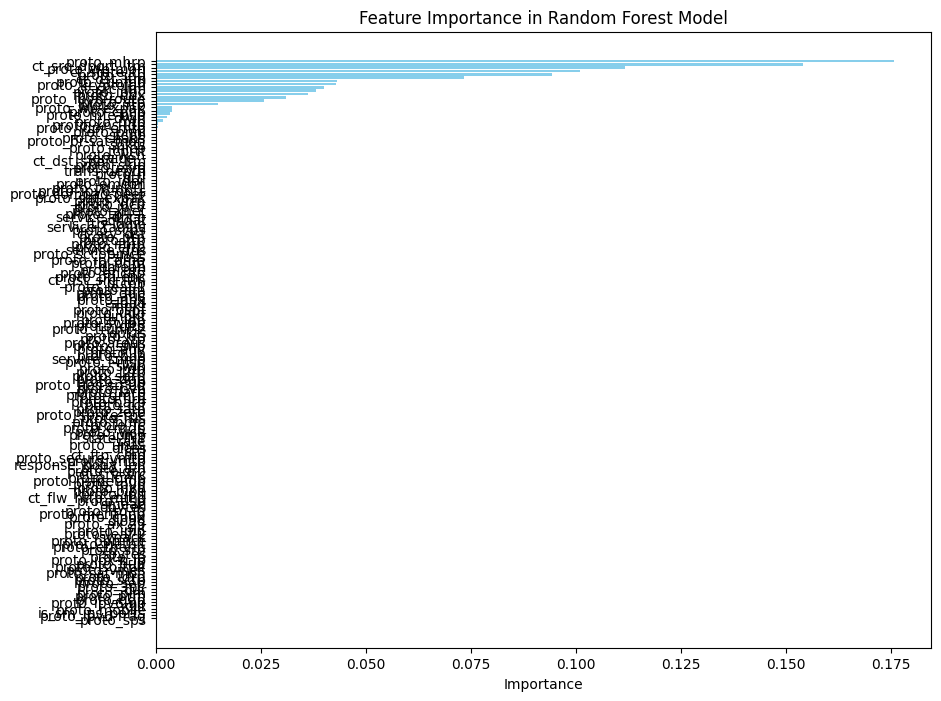

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Step 1: Extract feature importances
feature_importances = model.feature_importances_

# Step 2: Sort feature importances and match with feature names
features = X_train.columns  # Get feature names
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 3: Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()

##XGBoost:


In [ ]:

# Ensure only common features are in both training and testing datasets
common_features = list(set(X_train.columns) & set(X_test.columns))
X_train = X_train[common_features]
X_test = X_test[common_features]

# Initialize the XGBoost Classifier for multi-class classification
from xgboost import XGBClassifier
model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1


)

# Train and evaluate the model with attack categories as target
trained_model = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)

Model Evaluation Metrics:
Accuracy: 0.8041
Precision: 0.8258
Recall: 0.8164
F1 Score: 0.8211

Confusion Matrix:
[[29191  7809]
 [ 8322 37010]]


In [ ]:

# Ensure only common features are in both training and testing datasets
common_features = list(set(X_train.columns) & set(X_test.columns))
X_train = X_train[common_features]
X_test = X_test[common_features]

# Initialize the XGBoost Classifier for multi-class classification
from xgboost import XGBClassifier
model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train and evaluate the model with attack categories as target
trained_model = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)

Model Evaluation Metrics:
Accuracy: 0.9193
Precision: 0.9192
Recall: 1.0000
F1 Score: 0.9579

Confusion Matrix:
[[   11  1838]
 [    0 20922]]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
}

# Check for unique classes in y_train
print("Unique classes in y_train:", np.unique(y_train))

# If y_train has non-numeric labels, encode them
# Check if y_train is numeric
if not pd.api.types.is_numeric_dtype(y_train):
    # Create a LabelEncoder object
    label_encoder = LabelEncoder()

    # Fit the encoder on the training data
    label_encoder.fit(y_train)

    # Transform both training and testing data
    y_train = label_encoder.transform(y_train)
    # y_test = label_encoder.transform(y_test)  # Ensure y_test is transformed as well if needed


# Initialize XGBoost model
xgb_model = XGBClassifier(objective='multi:softmax', random_state=42, num_class=len(np.unique(y_train)) ) # Explicitly set num_class


# Perform Randomized Search with StratifiedKFold for better class distribution in folds
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=20,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), # Use StratifiedKFold
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)

# Train model with best parameters
best_xgb_model = random_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = best_xgb_model.predict(X_test)

print("Best Model Accuracy:", accuracy_score(y_test, y_pred))
print("Best Model Precision:", precision_score(y_test, y_pred))
print("Best Model Recall:", recall_score(y_test, y_pred))
print("Best Model F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Unique classes in y_train: [0 1]
Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8}
Best Cross-Validation Accuracy: 0.9879675549771338
Best Model Accuracy: 0.9201616090641606
Best Model Precision: 0.9200527704485488
Best Model Recall: 1.0
Best Model F1 Score: 0.9583619623471211
Confusion Matrix:
 [[   31  1818]
 [    0 20922]]
